# Load required Modules

In [55]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score

# Define functions

In [155]:
def initial_data_stats(df):

    "Takes a dataframe and produces a breakdown of all variabels and corresponding types, unique values, and counts including missing"

    variables = []
    dtypes = []
    count = []
    unique = []
    missing = []
    pc_missing = []
    for item in df.columns:
        variables.append(item)
        dtypes.append(df[item].dtype)
        count.append(len(df[item]))
        unique.append(len(df[item].unique()))
        missing.append(df[item].isna().sum())
        pc_missing.append(round((df[item].isna().sum() / len(df[item])) * 100, 2))

    output = pd.DataFrame({
        'variable': variables,
        'dtype': dtypes,
        'count': count,
        'unique': unique,
        'missing': missing,
        'pc_missing': pc_missing
    })
    return output



In [184]:
#Load data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")


initial_data_stats(train_data)

,variable,dtype,count,unique,missing,pc_missing
0,PassengerId,int64,891,891,0,0.00
1,Survived,int64,891,2,0,0.00
2,Pclass,int64,891,3,0,0.00
3,Name,object,891,891,0,0.00
4,Sex,object,891,2,0,0.00
5,Age,float64,891,89,177,19.87
6,SibSp,int64,891,7,0,0.00
7,Parch,int64,891,7,0,0.00
8,Ticket,object,891,681,0,0.00
9,Fare,float64,891,248,0,0.00


So The cabin category needs to be removed entirely, Age should be invetsigated for most accurate central tendency used to impute

Check Embarked for uniques, should be 3, does NA count as one?

Investigate Fare as it has many unique variables

Drop Ticket,


# Check overall statistical data

In [183]:
print("Stats = \n", train_data.describe())

survival_breakdown = train_data['Survived'].value_counts()
survival_rate = survival_breakdown[1] / (survival_breakdown.sum())
print("\n Survival rate =", survival_rate)

Stats = 
        PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  

 Survival rate = 0.3838383838383838


# Look for correlations

/var/folders/_h/6yk5cg152cv4ws6xvl8bx9kh0000gq/T/ipykernel_30144/1326023415.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train_data.corr()


<Axes: >

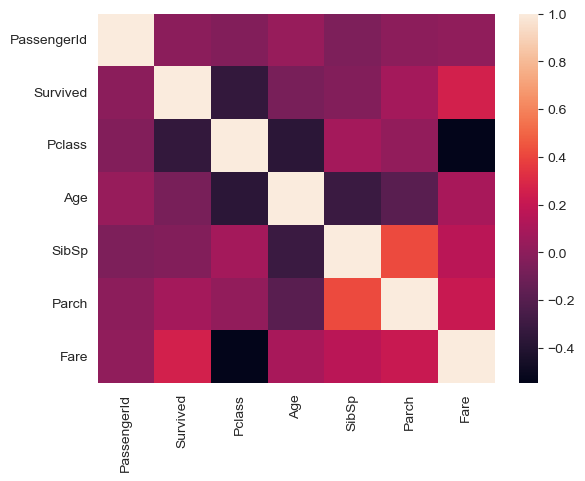

In [158]:
# plot the correlation map
corr = train_data.corr()

sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns)

It also suggests correlations between survival rate on Fare, Passenger class. Interestingly suggests minimal correlation between age and survival despite what the film suggests

# Total plots:
- Pclass and age and Fare to check distributions for imputation

- PClass, Age, Fare, Emabrkment vrs survival rate (data vrs counts and boxplot)

- Box plot of PArch and Sibs


# Investigate Passenger Fare and Pclass

[Text(0.5, 1.0, 'Class vrs survived')]

<Figure size 640x480 with 0 Axes>

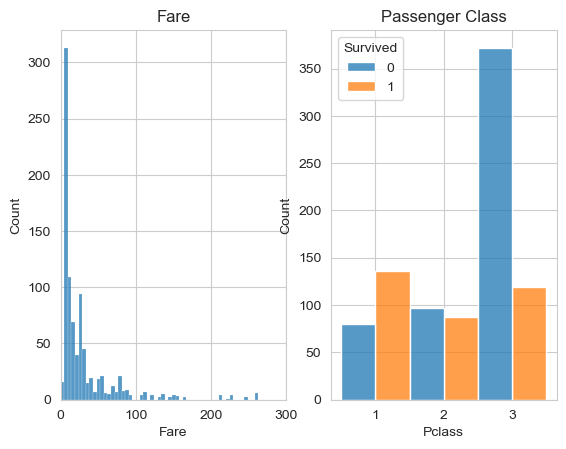

<Figure size 640x480 with 0 Axes>

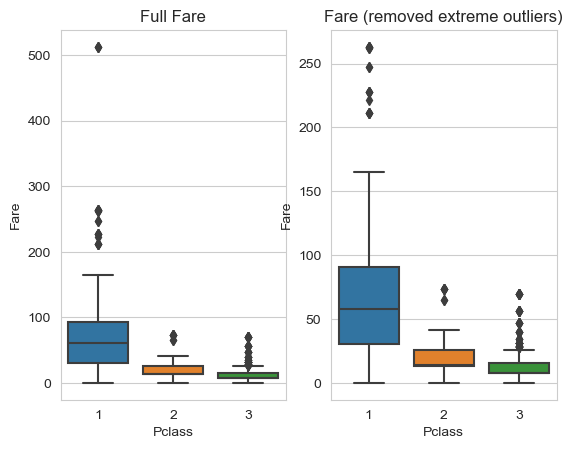

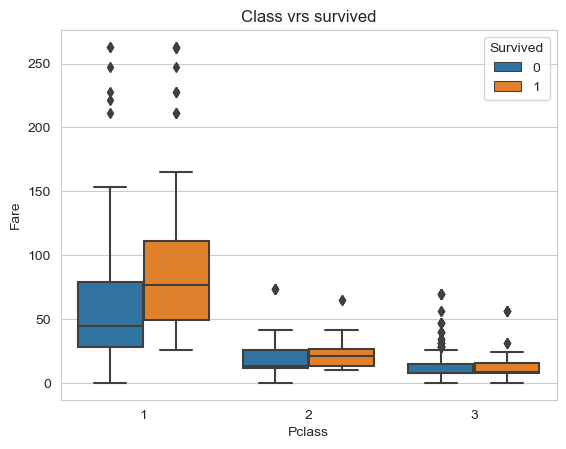

In [159]:

plt.figure(1)
fig, axes = plt.subplots(1, 2)
sns.histplot(ax=axes[0], data=train_data, x="Fare").set(title="Fare", xlim=(0, 300))
sns.histplot(ax=axes[1], data=train_data, x="Pclass", discrete=True, hue="Survived",multiple="dodge").set(title='Passenger Class')

plt.figure(3)
fig1, ax1, = plt.subplots(1, 2)
Fare_drop = train_data[train_data['Fare'] < 300]
sns.boxplot(ax=ax1[0], data=train_data, x="Pclass", y="Fare").set(title="Full Fare")

Fare_drop = train_data[train_data['Fare'] < 300]

sns.boxplot(ax=ax1[1], data=train_data, x="Pclass", y=Fare_drop.Fare).set(title="Fare (removed extreme outliers)")

plt.figure(6)
sns.boxplot(data=train_data, x="Pclass", y=Fare_drop.Fare, hue="Survived").set(title="Class vrs survived")

[Text(0.5, 1.0, '3rd Class')]

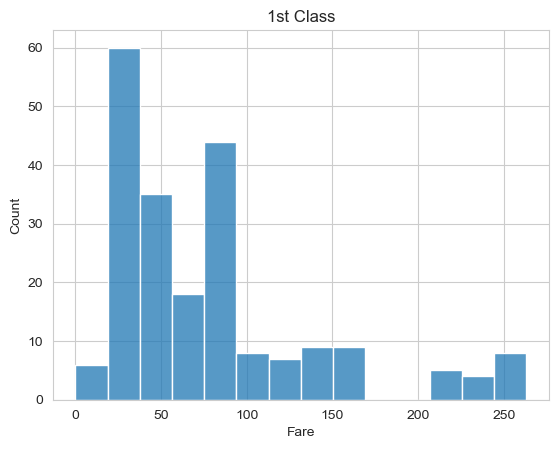

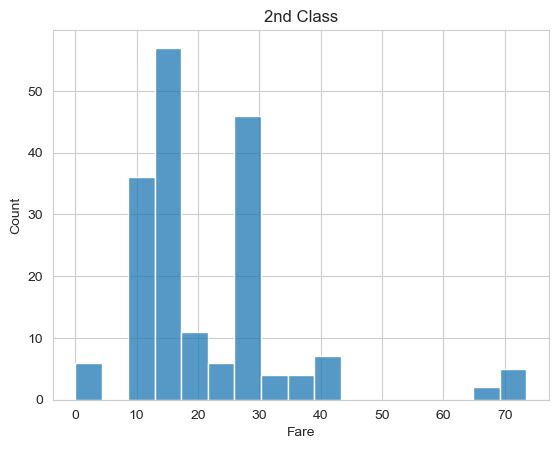

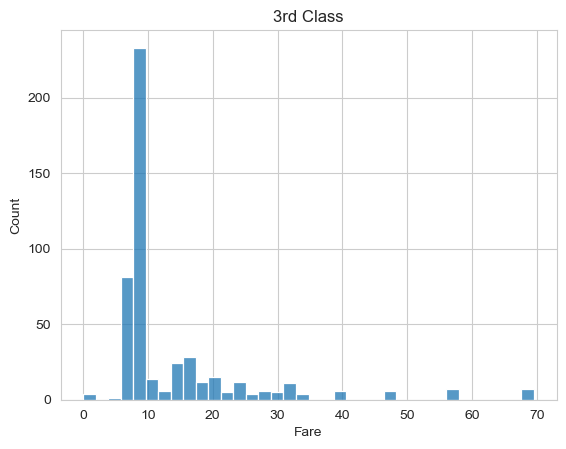

In [160]:
# drop outlier fare
train_data.drop(train_data[train_data['Fare'] > 300].index, inplace = True)

df = pd.DataFrame({"Class": train_data['Pclass'], "Fare": train_data['Fare']})

plt.figure(1)
sns.histplot(data=df[df["Class"]==1], x="Fare").set(title="1st Class")
plt.figure(2)
sns.histplot(data=df[df["Class"]==2], x="Fare").set(title="2nd Class")
plt.figure(3)
sns.histplot(data=df[df["Class"]==3], x="Fare").set(title="3rd Class")


# Age and Sex


<Axes: xlabel='Sex', ylabel='Count'>

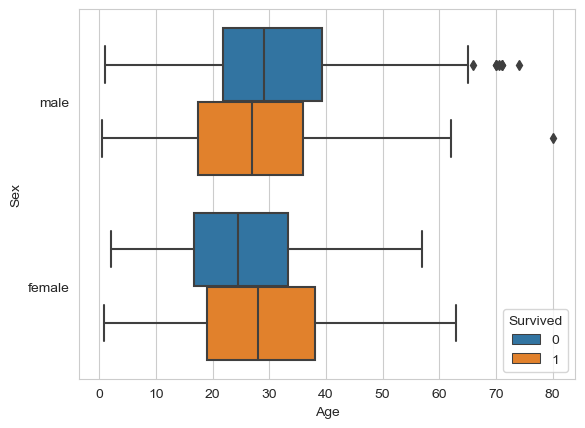

<Figure size 640x480 with 0 Axes>

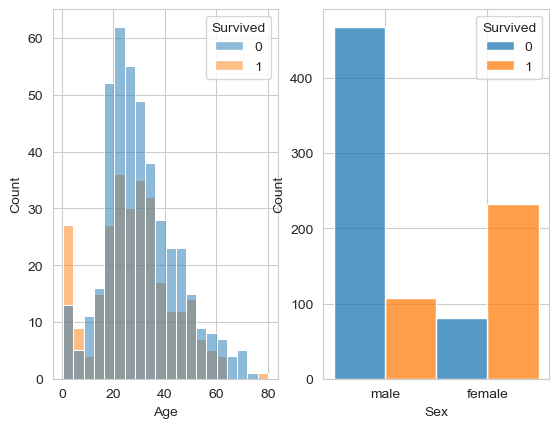

In [161]:
plt.figure(1)
sns.boxplot(data=train_data, x="Age", y="Sex", hue="Survived")

plt.figure(2)
fig, axes = plt.subplots(1, 2)
sns.histplot(ax=axes[0], x=train_data.Age, hue=train_data.Survived)
sns.histplot(ax=axes[1], x=train_data.Sex, hue=train_data.Survived, multiple='dodge')

# Embarkment

<Axes: xlabel='Embarked', ylabel='Percent'>

<Figure size 640x480 with 0 Axes>

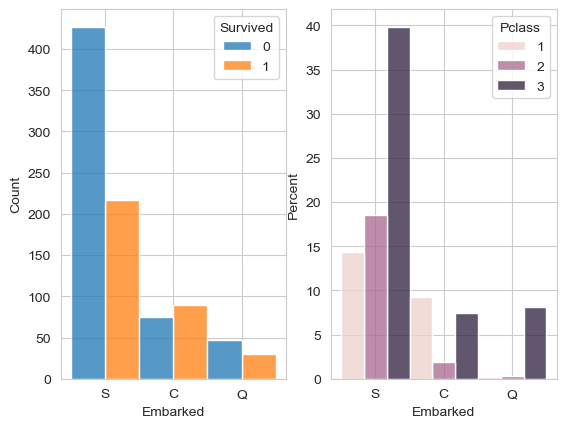

In [162]:
plt.figure(1)
fig, axes = plt.subplots(1, 2)
sns.histplot(ax=axes[0], data=train_data, x="Embarked", hue="Survived", multiple="dodge")
sns.histplot(ax=axes[1], data=train_data, x="Embarked", hue="Pclass", multiple="dodge", stat="percent")


* Survival rate is lower from S
* This makes sense following the idea that there's a large intake of 3rd class passengers by percentage

# Siblings and Parents

PArch count = 676
Sibling count = 605


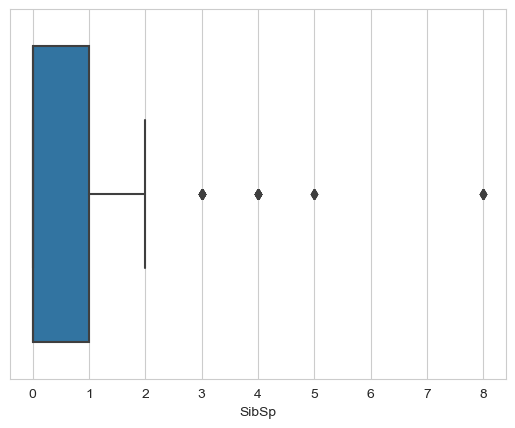

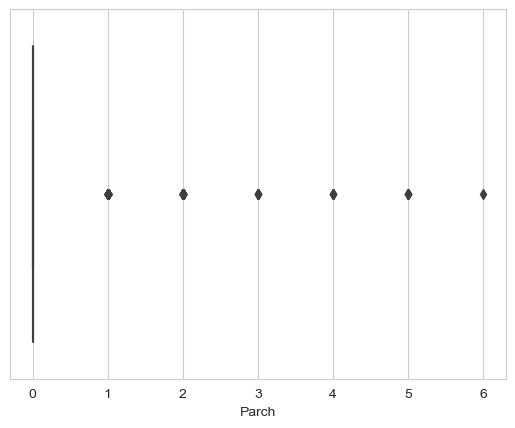

In [163]:
plt.figure(1)
sns.boxplot(data=train_data, x="SibSp")
plt.figure(2)
sns.boxplot(data=train_data, x="Parch")

print("PArch count =", (train_data['Parch'] == 0).sum())
print("Sibling count =", (train_data['SibSp'] == 0).sum())


# Decisons based on plots
* Remove max Fare, set max=300, It is an outlier
* Consider removing outliers age, >70 for safty or > 66 for most outliers
* Whilst SipSp and Parch are mostly zero, the low cardinality should be fine for a Random forest to handle
* Use Most frequent for Pclass, sex, Parch, SibSp and Embarked, Use mean for Age,
* Drop Id, Name, Survived, Ticket

# Ordinal encoding
1. Sex (since women are more likely to survive)
2. Pclass?
3. Embarked?
# One hot Encoding
1. Parch
2. SibSp
3. Embarked  (?)
4. Pclass (?)
5. Sex (?)

Test One hot and Ordinal for best



# Split features into seperate processing types

In [198]:
feature_age = [
    "Age"
]

feature_ordinal = ["Sex"]

features_num = [
    "SibSp", "Parch", "Fare"
]

features_cat = ["Embarked",  "Pclass"

                ]

my_cols = feature_age + features_num + features_cat + feature_ordinal
X = train_data[my_cols].copy()
X_test = test_data[my_cols].copy()


# Create Preprocessor and define imputation types

In [201]:
numerical_transformer = SimpleImputer(strategy='most_frequent')
age_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('age', age_transformer, feature_age),
        ('num', numerical_transformer, features_num),
        ('cat', categorical_transformer, features_cat),
        ('ord', ordinal_transformer, feature_ordinal)
    ])




# Create Pipeline, apply to test and train

In [202]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', RandomForestClassifier(50,random_state=0))])


X_train, X_valid, y_train, y_valid = train_test_split(
    train_data.drop(['Survived'], axis=1),
    train_data['Survived'],
    test_size=0.2, random_state=42)
my_pipeline.fit(X_train, y_train)
accuracy_score(y_valid, my_pipeline.predict(X_valid))

0.7821229050279329

# Check Cross validaition

In [203]:
X_train = pd.concat([X_train, X_valid])
y_train = pd.concat([y_train, y_valid])


print("Cross val score raw = ", cross_val_score(my_pipeline, X_train, y_train, cv=5))
print("Cross val mean = ", cross_val_score(my_pipeline, X_train, y_train, cv=5).mean())

Cross val score raw =  [0.79329609 0.82022472 0.79775281 0.80898876 0.80898876]
Cross val mean =  0.80585022911305


In [204]:
# Transform data with preprocessor
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)


# Grid search with forest params

In [205]:
# create the grid
n_estimators = [10, 100, 1000, 2000]
max_depth = [None, 5, 10, 20]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)

rf = RandomForestClassifier(random_state=42)

# search the grid
grid = GridSearchCV(estimator=rf,
                    param_grid=param_grid,
                    cv=3,
                    verbose=2,
                    n_jobs=-1)

grid_result = grid.fit(X_train, y_train)

print("Best params:", grid_result.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best params: {'max_depth': 10, 'n_estimators': 100}


In [206]:
leaf_samples = [1, 2, 3, 4, 5, 10]
param_grid = dict(min_samples_leaf=leaf_samples)

# create the model with new max_depth and n_estimators
rf = grid_result.best_estimator_

# search the grid
grid = GridSearchCV(estimator=rf,
                    param_grid=param_grid,
                    cv=3,
                    verbose=2,
                    n_jobs=-1)

grid_result = grid.fit(X_train, y_train)
print("Best params:", grid_result.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params: {'min_samples_leaf': 3}


In [207]:
rf = grid_result.best_estimator_
cross_val_score(rf, X_train, y_train, cv=5).mean()


0.8249450756386919

# Apply final fitted model and predict outcomes

In [208]:
X_test = test_data

X_test = preprocessor.transform(X_test)
predictions = np.round(rf.predict(X_test))


output = pd.DataFrame({'PassengerId': test_data.PassengerId,'Age': test_data['Age'],'Sex': test_data['Sex'], "Class": test_data['Pclass'], 'Survived': predictions[:]})

<Axes: xlabel='Age', ylabel='Survived'>

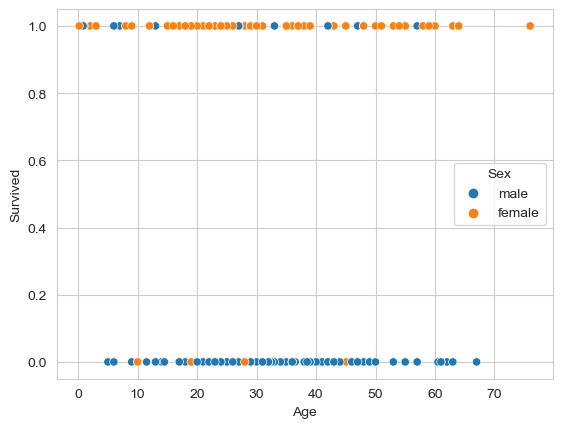

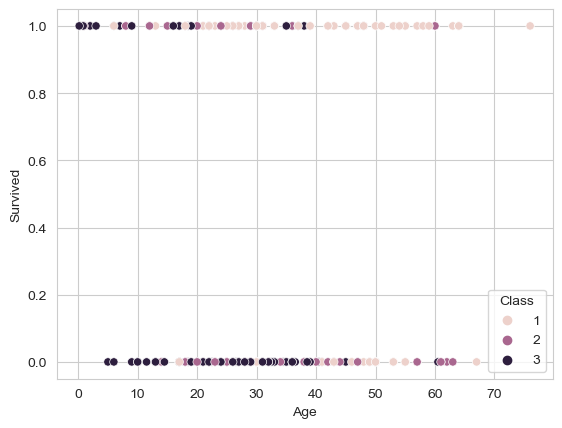

In [209]:
plt.figure(1)
sns.scatterplot(data=output, x=output["Age"], y=output["Survived"], hue="Sex")
plt.figure(2)
sns.scatterplot(data=output, x=output["Age"], y=output["Survived"], hue="Class")


Model accuracy is good, output seems reasonable with class, gender and age behaving mostly as expected